In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Visualization of brushfire grid, GVD, and paths
def plot_GVD(grid, GVD=None, path=None):
    fig, ax = plt.subplots()
    GVD_grid = np.copy(grid)
    if GVD:
        GVD_x, GVD_y = zip(*GVD)
        GVD_grid[GVD_x,GVD_y] = 20

    img1 = ax.imshow(GVD_grid, cmap="RdBu", alpha=0.6)
    obstacles = GVD_grid.copy()
    obstacles[obstacles < 0] = -2.0
    masked_data = np.ma.masked_where(obstacles > 0, obstacles)
    img2 = ax.imshow(masked_data, cmap="bwr")
    legend_elements = [Patch(facecolor='blue', label='Obstacle')]
    if GVD: legend_elements.append(Patch(facecolor='#83b1d3', label='GVD'))

    if path:
        path_x, path_y = zip(*path)
        GVD_grid[path_x,path_y] = 40.0
        grid_path = GVD_grid.copy()
        grid_path = np.ma.masked_where(grid_path != 40.0, grid_path)
        img3 = ax.imshow(grid_path, cmap="cool_r", interpolation="nearest") 
        legend_elements.append(Patch(facecolor='#e741f6', label='path'))

    ax.legend(handles=legend_elements)
    plt.show()

In [2]:
# Generation of example environments
# Feel free to generate more using these as baseline

def generate_world_1(width=100, height=100):  
    x_list = np.linspace(0, width-1, width)
    y_list = np.linspace(0, height-1, height)  

    grid_world = np.zeros((width, height))
    grid_world = create_rectangle_obstacle(grid_world, 30, 70, 40, 60, -1)

    return grid_world, x_list, y_list


def generate_world_2(width=100, height=100):    
    x_list = np.linspace(0, width-1, width)
    y_list = np.linspace(0, height-1, height)
  
    grid_world = np.zeros((width, height))  
    grid_world = create_rectangle_obstacle(grid_world, 20, 40, 45, 85, -1)
  
    # triangle obstacle
    for x in range(60, 91):
        for y in range(20, 91-x+21):
              grid_world[int(x), int(y)] = -2

    return grid_world, x_list, y_list


def generate_world_3(width=100, height=100):   
    x_list = np.linspace(0, width-1, width)
    y_list = np.linspace(0, height-1, height)
  
    grid_world = np.zeros((width, height))
    grid_world = create_rectangle_obstacle(grid_world, 15, 45, 20, 50, -1)
    grid_world = create_circle_obstacle(grid_world, 75.0, 30.0, 12, -2)
    grid_world = create_circle_obstacle(grid_world, 50.0, 75.0, 16, -3)
  
    return grid_world, x_list, y_list


def generate_world_4(width=100, height=100):   
    x_list = np.linspace(0, width-1, width)
    y_list = np.linspace(0, height-1, height)
    grid_world = np.zeros((width, height))

  # triangle obstacle
    for x in range(50, 81):
        for y in range(20, 21+x-50):
              grid_world[int(x), int(y)] = -1

    grid_world = create_rectangle_obstacle(grid_world, 30, 60, 55, 85, -2)
    grid_world = create_circle_obstacle(grid_world, 25.0, 30.0, 12, -3)
  
    return grid_world, x_list, y_list


def create_circle_obstacle(grid_world, center_x, center_y, radius, obst_id):
    c_x, c_y, r_2 = center_x, center_y, radius
    for x in range(grid_world.shape[0]):
        for y in range(grid_world.shape[1]):
              if np.sqrt((x - c_x)**2 + (y - c_y)**2) < r_2:
                grid_world[int(x), int(y)] = obst_id
    return grid_world


def create_rectangle_obstacle(grid_world, lower_x, upper_x, lower_y, upper_y, obst_id):
    grid_world[lower_x: upper_x, lower_y: upper_y] = obst_id
    return grid_world

In [3]:
# Utility functions: You may use or modify any of these

# Return valid neighbors on the grid of cell [i,j]
def neighbors(grid, i, j):
    n = []

    if i-1 >= 0:
        n.append((i-1,j))
        if j-1 >= 0: n.append((i-1,j-1))
        if j+1 < grid.shape[1]: n.append((i-1,j+1))
    if i+1 < grid.shape[0]: 
        n.append((i+1,j))
        if j-1 >= 0: n.append((i+1,j-1))
        if j+1 < grid.shape[1]: n.append((i+1,j+1))
    if j-1 >= 0: n.append((i,j-1))
    if j+1 < grid.shape[1]: n.append((i,j+1))

    return n


# Shortest path from any cell in env to a cell in GVD via gradient ascent
def path_to_GVD(grid, GVD, cell):
    path = [cell]
    while [path[-1][0],path[-1][1]] not in GVD:
        print(path[-1])
        next = path[-1]
        for n in neighbors(grid, path[-1][0], path[-1][1]):
            if grid[n[0], n[1]] > grid[next[0], next[1]]:
                next = n;print(next)  
        path.append(next)
    return path


# Shortest path between two points on GVD
def GVD_path(grid, GVD, A, B):
    GVD = set(GVD)
    closed = set([])
    open = [A]
    pointers = {}

    while len(open) > 0:
        cell = open.pop(0)
        new_neighbors = GVD.intersection(set(neighbors(grid, cell[0], cell[1]))) - closed

        if B in new_neighbors:
            pointers[B] = cell
            path = [B]
            while path[-1] != A:
                
                next = pointers[path[-1]]
                path.append(next)
            return list(reversed(path))

        open += list(new_neighbors)
        closed.update(new_neighbors)
        pointers.update(dict.fromkeys(list(new_neighbors), cell))
    return None

In [4]:
def wavefrontmaker(theGrid):
    wavefront1=[];wavefront2=[];wavefront3=[];wavefront4=[];wavefront5=[];wavefront6=[];wavefront7=[]
    for i in range(0,theGrid.shape[0]):
        for j in range(0,theGrid.shape[1]):
            if theGrid[i,j]==1:
                continue
            elif theGrid[i,j]==  -1:
                
                Z= neighbors(theGrid,i,j)
                
                for l in Z:
                    #print(theGrid[l])
                    if theGrid[l]==0:
                        
                        
                        #print(theGrid[l])
                        wavefront1.append(l)
                        theGrid[l]=1
            elif theGrid[i,j]==  -2:
                
                Z= neighbors(theGrid,i,j)
                
                for l in Z:
                    #print(theGrid[l])
                    if theGrid[l]==0:
                        
                       
                        #print(theGrid[l])
                        wavefront2.append(l)
                        theGrid[l]=1
            elif theGrid[i,j]==  -3:
                
                Z= neighbors(theGrid,i,j)
                
                for l in Z:
                    #print(theGrid[l])
                    if theGrid[l]==0:
                        
                        theGrid[l]=1
                        #print(theGrid[l])
                        wavefront3.append(l)
                        theGrid[l]=1
            elif (i== 0):
                wavefront4.append((i,j))
                theGrid[i,j]=1
            elif(i== theGrid.shape[1]-1):
                wavefront5.append((i,j))
                theGrid[i,j]=1
            elif (j== 0):
                wavefront6.append((i,j))
                theGrid[i,j]=1
            elif(j== theGrid.shape[0]-1):
                wavefront7.append((i,j))
                theGrid[i,j]=1

            
    
    wavefront4=  wavefront4[1:-1];wavefront5=  wavefront5[1:-1];wavefront6=  wavefront6[1:-1];wavefront7=  wavefront7[1:-1]
    W= [wavefront1,wavefront2,wavefront3,wavefront4,wavefront5,wavefront6,wavefront7]
    return W,theGrid     
                    

                

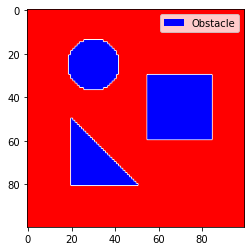

In [5]:
z_1, x, y = generate_world_4()
plot_GVD(z_1)

In [6]:
W,theGrid= wavefrontmaker(z_1)


In [7]:
cellmap=np.zeros((z_1.shape[0],z_1.shape[1]))
GVD=[]
iter=1

while iter<100:
    
    if 0 not in theGrid:
        print(iter)
        break
    tempwave=[]

    for wavefront in W:
        valueofWF= W.index(wavefront)+1
        for l in wavefront:
        
            z=neighbors(theGrid,l[0],l[1])
    
            for i in z:

                if theGrid[i]==0:
               
                    theGrid[i]=iter+1
                    cellmap[i]=valueofWF       
                    tempwave.append(i)
        wavefront.extend(tempwave)
    iter=iter+1

20


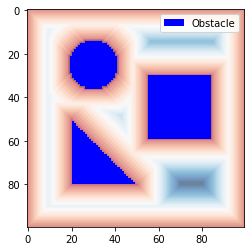

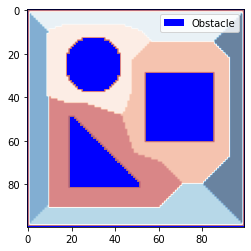

In [8]:

plot_GVD(theGrid, GVD=None, path=None)
plot_GVD(cellmap, GVD=None, path=None)


In [9]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

def GetGVD(cellmap):
    gvd=[]
    newGVD=[]
    initial=cellmap[0,0]
    for i in range(0,cellmap.shape[0]-1):
        for j in range(0,cellmap.shape[1]-1):
            if cellmap[i,j]==0:
                z= neighbors(cellmap,i,j)
                for l in z:
                    if cellmap[l]!= 0:
                        value=cellmap[l]
                        break
                cellmap[i,j]=value
                
                
    
    for i in range(0,cellmap.shape[0]-1):
        for j in range(0,cellmap.shape[1]-1):
            if cellmap[i,j]!=cellmap[i+1,j]:
                z= neighbors(cellmap,i,j)
                for l in z:
                    if cellmap[l]== 0:
                        break
                    else:
                        GVD.append([i,j])
                        GVD.append([i+1,j])
                        #print ('appended')
            elif cellmap[i,j]!=cellmap[i,j+1]:
                z= neighbors(cellmap,i,j)
                for l in z:
                    if cellmap[l]== 0:
                        break
                    else:
                        GVD.append([i,j])
                        GVD.append([i,j+1])
                
    
    for i in range(0,len(GVD)):
            if (i!=1 or i!=cellmap.shape[0]-2 or j!=1 or j!= cellmap.shape[1]-1):
                newGVD.append(GVD[i])
    return newGVD

In [10]:
GVD= GetGVD(cellmap)
FinalGVD=[]
f= get_unique_list(GVD)
for i in range(0,len(f)):
    if f[i][1]!=98 and f[i][0]!=98 and f[i][1]!=0 and f[i][0]!=0 and f[i][1]!=99 and f[i][0]!=99 and f[i][1]!=1 and f[i][0]!=1:
        FinalGVD.append(f[i])
print(len(FinalGVD))


872


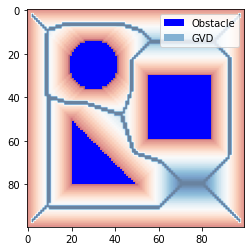

In [11]:
#FinalGVD=np.array(FinalGVD)
#plt.scatter(FinalGVD[:,0],FinalGVD[:,1])
plot_GVD(theGrid, GVD=FinalGVD, path=None)
#print(theGrid) 
#print(FinalGVD)


In [12]:
#Input Your Two  Points here:
A=[1,20]
B=[95,70]
AonGVD= path_to_GVD(theGrid,FinalGVD,A)
BonGVD= path_to_GVD(theGrid,FinalGVD,B)
mew = set(tuple(row) for row in FinalGVD)

#c=GVD_path(theGrid, mew, AonGVD[-1], BonGVD[-1])
#print(c)

[1, 20]
(2, 20)
(2, 20)
(3, 20)
(3, 20)
(4, 20)
(4, 20)
(5, 20)
(5, 20)
(6, 20)
[95, 70]
(94, 70)
(94, 70)
(93, 70)
(93, 70)
(92, 70)
(92, 70)
(91, 70)
(91, 70)
(90, 70)
(90, 70)
(89, 70)
(89, 70)
(88, 70)
(88, 70)
(87, 70)
(87, 70)
(86, 70)
(86, 70)
(85, 70)
(85, 70)
(84, 70)
(84, 70)
(83, 70)
(83, 70)
(82, 70)
(82, 70)
(81, 70)


In [13]:
L=[]
for i in FinalGVD:
    #print(tuple(i))
    L.append(tuple(i))
print(type(L))

<class 'list'>


In [14]:
path3=GVD_path(theGrid, L, tuple(AonGVD[-1]), tuple(BonGVD[-1]))
FinalPath= AonGVD+path3+BonGVD















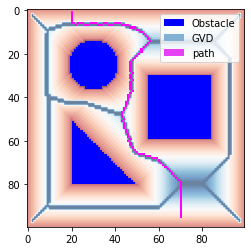

In [15]:
plot_GVD(theGrid, GVD=FinalGVD, path=FinalPath)
#bring a bucket and a mop for this wet ass Path